In [ ]:
# UCLA KICKING BASED ON TEMPERATURE

In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings("ignore")

# Connect to my database

conn = psycopg2.connect(
    host="",
    port="",  
    database="",  
    user="",  
    password=""  
)

cursor = conn.cursor()

In [2]:
# Query to retrieve UCLA kicking stats along with weather, altitude, and distance
query = """
SELECT date, location, opponent, 
       fg_1_19, fg_20_29, fg_30_39, fg_40_49, fg_50_plus, longest_fg, fg_percentage, fg_made, xp_made, points_scored, temp_f, precipitation_in, windspeed_mph, altitude_m, distance_from
FROM UCLA_Kicking_Stats;
"""

ucla_kicking = pd.read_sql(query, conn)

# Display the first few rows of the data
ucla_kicking.head()

,date,location,opponent,fg_1_19,fg_20_29,fg_30_39,fg_40_49,fg_50_plus,longest_fg,fg_percentage,fg_made,xp_made,points_scored,temp_f,precipitation_in,windspeed_mph,altitude_m,distance_from
0,2023-09-02,H,Coastal Carolina,0,0,1,1,0,47,100.0,2,3,9,73.4,0.03,6.6,263.0,0.00
1,2023-09-09,@,San Diego State,0,0,0,0,0,0,0.0,0,5,5,76.1,0.00,12.9,25.0,117.10
2,2023-09-16,H,North Carolina Central,0,1,0,0,0,24,100.0,1,8,11,68.6,0.00,5.6,263.0,0.00
3,2023-09-23,@,Utah,0,0,0,0,0,0,0.0,0,1,1,57.5,0.00,10.5,1433.0,586.62
4,2023-10-07,H,Washington State,0,0,2,0,0,37,50.0,2,1,7,73.2,0.00,6.1,263.0,0.00


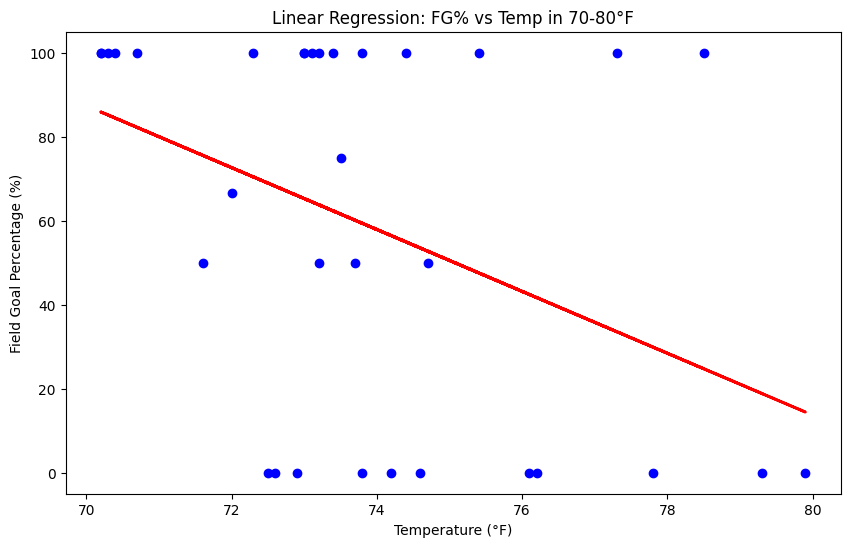

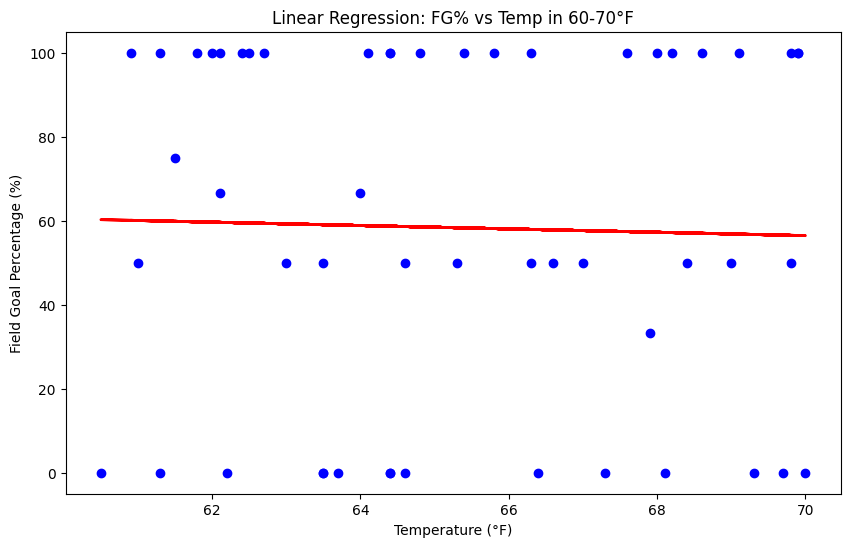

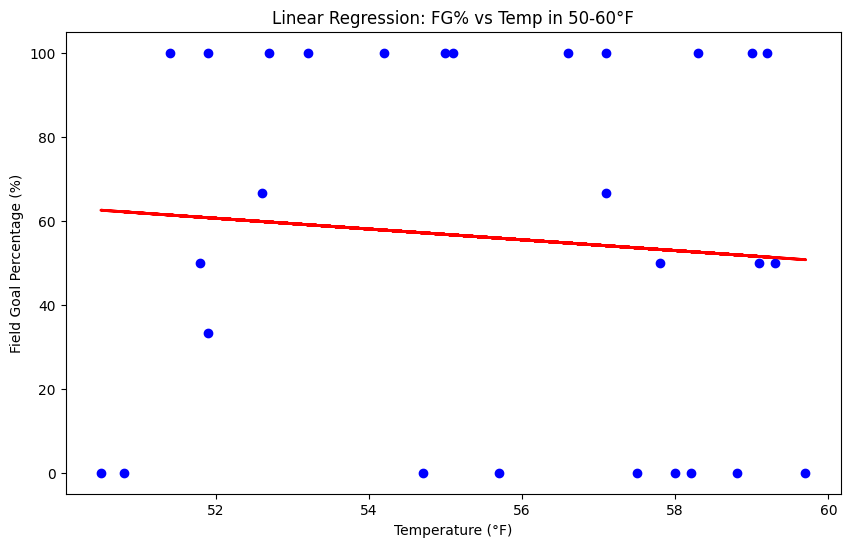

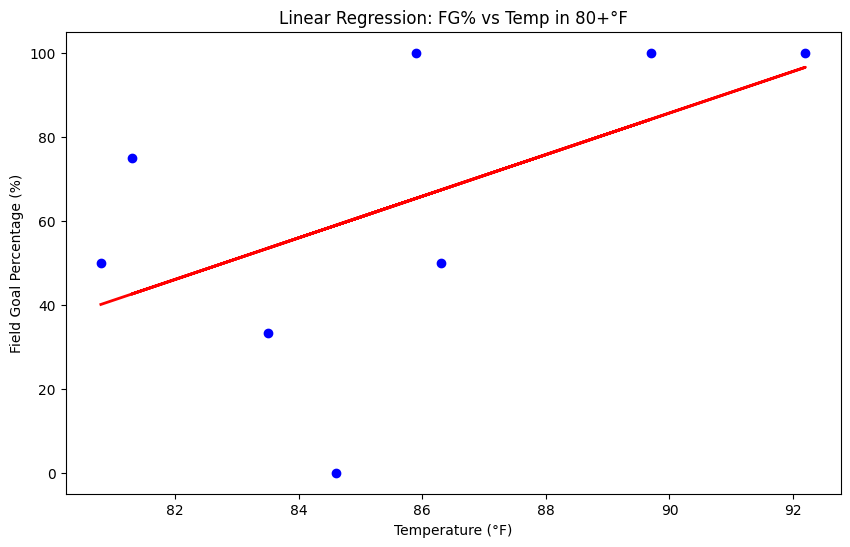

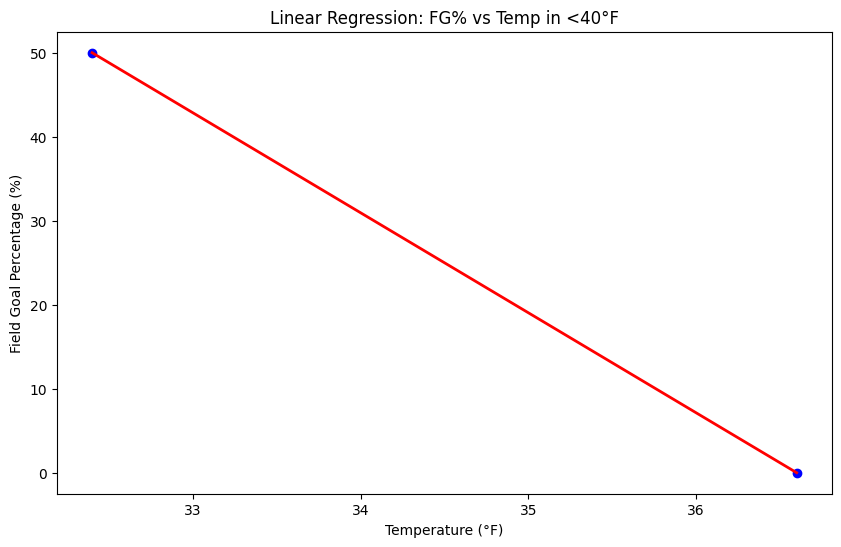

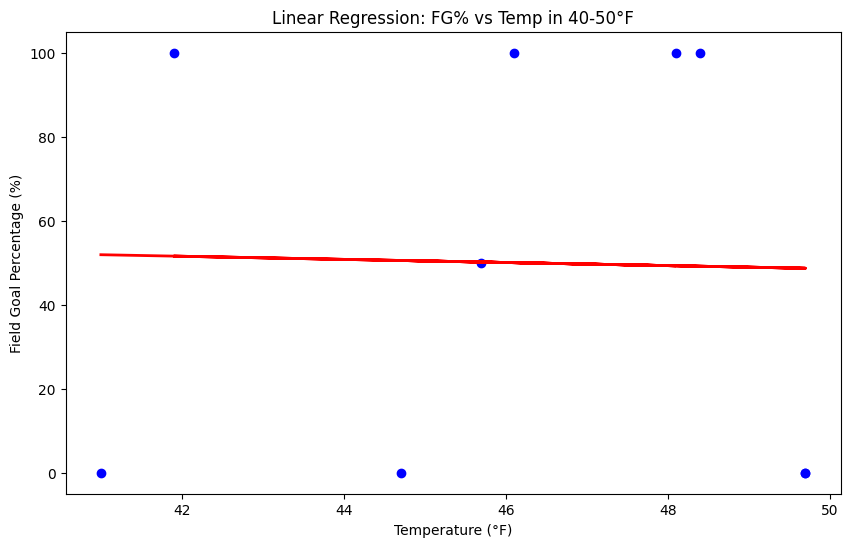

In [3]:

from sklearn.linear_model import LinearRegression



ucla_kicking['Temp_Range'] = pd.cut(
    ucla_kicking['temp_f'], 
    bins=[-np.inf, 40, 50, 60, 70, 80, np.inf], 
    labels=['<40', '40-50', '50-60', '60-70', '70-80', '80+']
)

# For each temperature range, we fit a linear regression model
for temp_range in ucla_kicking['Temp_Range'].unique():
    temp_data = ucla_kicking[ucla_kicking['Temp_Range'] == temp_range]

    X = temp_data[['temp_f']]
    y = temp_data['fg_percentage']

    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue')
    plt.plot(X, y_pred, color='red', linewidth=2)
    plt.title(f'Linear Regression: FG% vs Temp in {temp_range}°F')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Field Goal Percentage (%)')
    plt.show()


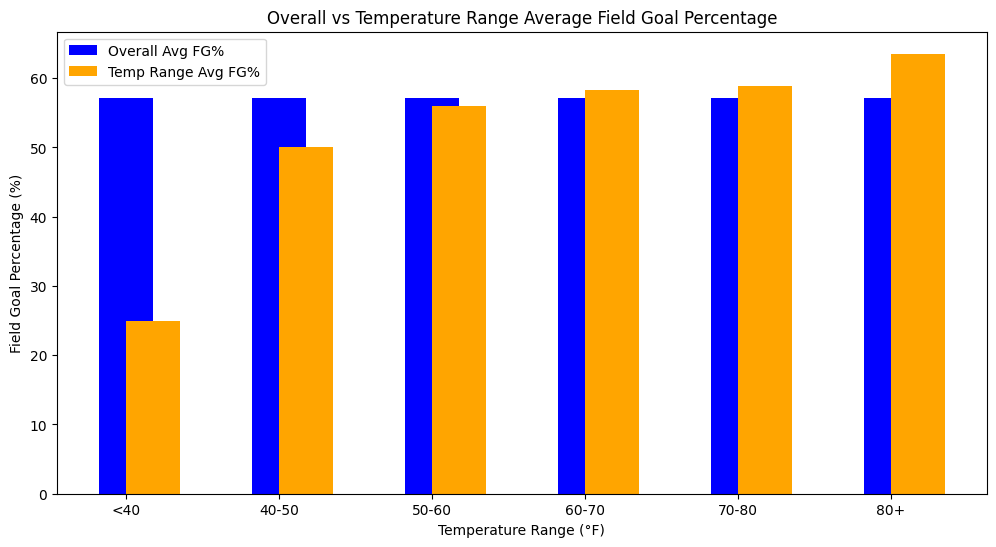

In [4]:
# overall average FG%
overall_avg_fg = ucla_kicking['fg_percentage'].mean()

# Calculate average FG% for each temperature range
temp_avg_fg = ucla_kicking.groupby('Temp_Range')['fg_percentage'].mean().reindex(['<40', '40-50', '50-60', '60-70', '70-80', '80+'])

# Prepare data for plotting
avg_data = pd.DataFrame({
    'Temp_Range': temp_avg_fg.index,
    'Overall_Avg_FG%': [overall_avg_fg] * len(temp_avg_fg),
    'Temp_Range_Avg_FG%': temp_avg_fg.values
})

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(avg_data['Temp_Range'], avg_data['Overall_Avg_FG%'], width=bar_width, label='Overall Avg FG%', color='blue', align='center')
plt.bar(avg_data['Temp_Range'], avg_data['Temp_Range_Avg_FG%'], width=bar_width, label='Temp Range Avg FG%', color='orange', align='edge')

plt.xlabel('Temperature Range (°F)')
plt.ylabel('Field Goal Percentage (%)')
plt.title('Overall vs Temperature Range Average Field Goal Percentage')
plt.legend()

plt.show()
